In [61]:
import pandas as pd
import numpy as np
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Get data from OpenPrescribing GBG measure equivalent view

In [62]:
sql = """
SELECT
  date(month) as month,
  pct,
  practice,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN items ELSE 0 END) AS items,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN possible_savings ELSE 0 END) AS possible_savings,
  SUM(net_cost) AS net_cost
FROM
  ebmdatalab.alex.vw__ghost_generic_measure_paper
INNER JOIN
  ebmdatalab.hscic.practices
ON
  practice = code
  AND setting = 4
GROUP BY
  month,
  pct,
  practice
"""
ghost_df = bq.cached_read(sql, csv_path='ghost_generics.zip')

In [63]:
ghost_df.head()

,month,pct,practice,items,possible_savings,net_cost
0,2014-03-01,08A,G83017,0,0.00,24592.98
1,2014-03-01,08V,F84718,1,-2.43,38571.20
2,2014-03-01,06F,E81037,208,16.21,97506.25
3,2014-03-01,15C,L81670,9,8.63,34022.04
4,2014-03-01,08D,F85665,2,-4.87,4919.80


In [64]:
##Get Data on EHRs

In [65]:
epr = pd.read_csv('GPSoC/complete.csv')
epr = epr.rename(index=str, columns={"Principal Supplier": "Principal_Supplier",
                                     "Principal System": "Principal_System"})
epr['Date'] = pd.to_datetime(epr['Date'])
epr.loc[epr['Principal_Supplier']=='TPP','Principal_Supplier'] = 'SystmOne'
epr.loc[epr['Principal_Supplier']=='INPS','Principal_Supplier'] = 'Vision'
epr = epr.drop('Unnamed: 0', axis=1)
epr.head(5)

,Date,ODS,Principal_Supplier,Principal_System
0,2016-04-01,A81622,SystmOne,SystmOne (GPSoC)
1,2016-04-01,A82018,EMIS,EMIS Web
2,2016-04-01,A82041,EMIS,EMIS Web
3,2016-04-01,A86026,SystmOne,SystmOne (GPSoC)
4,2016-04-01,B81120,SystmOne,SystmOne (GPSoC)


In [69]:
numbers = practice[['month','practice', 'possible_savings','net_cost']]
first = epr.loc[epr['Date']=='2016-03-01',['ODS','Principal_Supplier']]
last = epr.loc[epr['Date']=='2018-12-01',['ODS','Principal_Supplier']]
by_epr = numbers.merge(epr, how='left', left_on=['practice','month'], right_on=['ODS','Date'])
by_epr = by_epr.merge(first,
                      how='left',
                      left_on='practice',
                      right_on='ODS',
                      suffixes=('','_first')
                     )
'''by_epr = by_epr.merge(last,
                      how='left',
                      left_on='practice',
                      right_on='ODS',
                      suffixes=('','_last')
                     )'''
by_epr.loc[by_epr['month']<'2016-03-01','Principal_Supplier'] = by_epr.loc[by_epr['month']<'2016-03-01','Principal_Supplier_first']
#by_epr.loc[by_epr['month']>'2018-12-01','Principal_Supplier'] = by_epr.loc[by_epr['month']>'2018-12-01','Principal_Supplier_last']
by_epr = by_epr.drop(columns=['Date',
                              'ODS',
                              'Principal_System',
                              'ODS_first',
                              'Principal_Supplier_first'])#,
                              #'ODS_last',
                              #'Principal_Supplier_last'])
by_epr['Principal_Supplier'] = by_epr['Principal_Supplier'].str.strip()
by_epr2 = by_epr.groupby(['month','Principal_Supplier']).sum()
by_epr2 = by_epr2.unstack()
by_epr2.head(5)

possible_savings                                net_cost  \
Principal_Supplier             EMIS Microtest SystmOne  Vision         EMIS   
month                                                                         
2013-05-01                 10446.77   1784.29 73738.64 5581.46 203238163.99   
2013-06-01                 -2563.73   1859.71 63388.98 2988.00 188462254.12   
2013-07-01                -10055.73    785.86 61007.63 2142.51 203442934.51   
2013-08-01                 -3948.33    534.06 57048.07  979.68 195651805.43   
2013-09-01                  9180.06    736.48 60155.03  885.89 190777930.29   

                                                        
Principal_Supplier  Microtest     SystmOne      Vision  
month                                                   
2013-05-01         5170136.52 135160903.38 26857906.96  
2013-06-01         4789722.81 124830516.81 25017331.23  
2013-07-01         5204418.73 134816177.08 26813963.72  
2013-08-01         5093040.22 130271807.21 25866000.03  
2013-09-01         4851201.65 125962964.12 25384134.39

In [80]:
ehr_by_ccg = pd.merge(by_epr, practice[['practice', 'month' ,'calc_val']].drop_duplicates(), left_on=['practice', 'month'], right_on= ['practice', 'month'], how='left')
ehr_by_ccg.head(5)

,month,practice,possible_savings,net_cost,Principal_Supplier,calc_val
0,2013-05-01,A81001,3.29,32027.35,SystmOne,0.01
1,2013-06-01,A81001,-2.13,27785.40,SystmOne,-0.01
2,2013-07-01,A81001,0.00,30353.65,SystmOne,0.00
3,2013-08-01,A81001,3.35,30748.65,SystmOne,0.01
4,2013-09-01,A81001,32.18,29544.21,SystmOne,0.11


In [82]:
df_sysone_prac = ehr_by_ccg.loc[ehr_by_ccg['Principal_Supplier']=='SystmOne']
df_sysone_prac.head(5)

,month,practice,possible_savings,net_cost,Principal_Supplier,calc_val
0,2013-05-01,A81001,3.29,32027.35,SystmOne,0.01
1,2013-06-01,A81001,-2.13,27785.40,SystmOne,-0.01
2,2013-07-01,A81001,0.00,30353.65,SystmOne,0.00
3,2013-08-01,A81001,3.35,30748.65,SystmOne,0.01
4,2013-09-01,A81001,32.18,29544.21,SystmOne,0.11


# Practice level data

In [83]:
practice = ghost_df.copy()
practice['calc_val'] = (practice['possible_savings']/practice['net_cost'])*100
practice['month'] = pd.to_datetime(practice['month'])
practice = practice.sort_values(['practice','month'])
practice = practice.loc[practice['month']>='2013-05-01']
practice = practice.replace([np.inf, -np.inf], np.nan)
practice.head()

,month,pct,practice,items,possible_savings,net_cost,calc_val
654375,2013-05-01,00K,A81001,3,3.29,32027.35,0.01
764778,2013-06-01,00K,A81001,3,-2.13,27785.40,-0.01
49794,2013-07-01,00K,A81001,0,0.00,30353.65,0.00
149111,2013-08-01,00K,A81001,3,3.35,30748.65,0.01
255686,2013-09-01,00K,A81001,1,32.18,29544.21,0.11


# CCG level data

In [84]:
ccg = ghost_df.copy()
ccg['month'] = pd.to_datetime(ccg['month'])
ccg = ccg.groupby(['pct','month'],as_index=False).sum()
ccg['calc_val'] = (ccg['possible_savings']/ccg['net_cost'])*100
ccg = ccg.sort_values(['pct','month'])
ccg = ccg.loc[ccg['month']>='2013-05-01']
ccg = ccg.replace([np.inf, -np.inf], np.nan)
ccg.head()

,pct,month,items,possible_savings,net_cost,calc_val
33,00C,2013-05-01,1599,182.10,837980.56,0.02
34,00C,2013-06-01,937,262.12,765673.64,0.03
35,00C,2013-07-01,723,597.99,838610.10,0.07
36,00C,2013-08-01,775,107.67,815297.72,0.01
37,00C,2013-09-01,815,229.13,771885.32,0.03


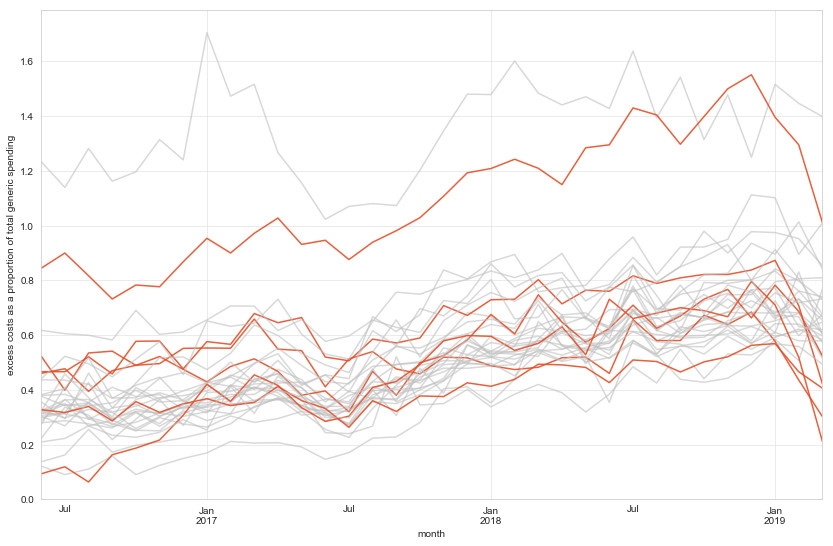

In [85]:
##this is finding those CCGs who have changed
top_n = ccg.loc[ccg['month']=='2019-01-01']
top_n = top_n.sort_values('calc_val',ascending=False)
top_n = top_n.head(30)
before = top_n[['pct','calc_val']].set_index('pct')
top_n = top_n[['pct']]
top_n = top_n.set_index('pct')

most_recent = ccg.loc[ccg['month']==ccg['month'].max(),['pct','calc_val']]
most_recent = most_recent.merge(top_n,how='right',left_on='pct',right_index=True)
most_recent = most_recent.set_index('pct')

'''
change = before - most_recent
change = change - change.min()
change = change / (change.max()-change.min())
change = change['calc_val']
#change = 1-change
'''
change = before - most_recent
change = change / before
change = change['calc_val']

ccg_unstacked = ccg.loc[ccg['month']>='2016-06-01']
ccg_unstacked = ccg_unstacked.merge(top_n,how='right',on='pct')
ccg_unstacked = ccg_unstacked.groupby(['month','pct']).sum()
ccg_unstacked = ccg_unstacked.unstack()

#from matplotlib import cm
#colors = [cm.coolwarm(x) for x in change]
def color_pick(x):
    if x < 0.25:
        return (0.75,0.75,0.75,0.6)
    else:
        return (0.9,0.3,0.15,0.9)
colors = [color_pick(x) for x in change]

f = plt.figure(figsize=(14, 9))
layout = gridspec.GridSpec(1, 1, figure=f)
ax = plt.subplot(layout[0])
ccg_unstacked['calc_val'].plot(ax=ax,color=colors)
#ax.axvline('2018-12-01',color='r',linestyle=':', label='DataLab Discover and Announce GBG')
#ax.axvline('2019-02-01',color='k',linestyle='--', label='SystmOne deploy fix') ## it was last week of Feb, I think a case for setting as march
ax.set_ylabel('excess costs as a proportion of total generic spending')
ax.set_ylim(0,)
ax.legend().remove()
plt.savefig(r'gbg_images\CCGs_that_have_changed.png')
plt.show()

In [86]:
## ensuring the format is consistent for pounds and pence
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [87]:
## here we calculate ranges for december 2012
ccg_dec18 = ccg.copy().loc[(ccg["month"]== "2018-12-01")]
ccg_dec18.describe()

,items,possible_savings,net_cost,calc_val
count,196.00,196.00,196.00,196.00
mean,14252.16,4430.38,1784261.53,0.24
std,20319.74,6088.59,1046548.64,0.29
min,71.00,-197.52,50003.30,-0.02
25%,568.50,72.26,1150486.67,0.01
50%,4477.50,1590.20,1523225.40,0.13
75%,21404.00,6701.10,2073027.21,0.42
max,142769.00,34664.49,7234775.70,1.55


# Most recent month map


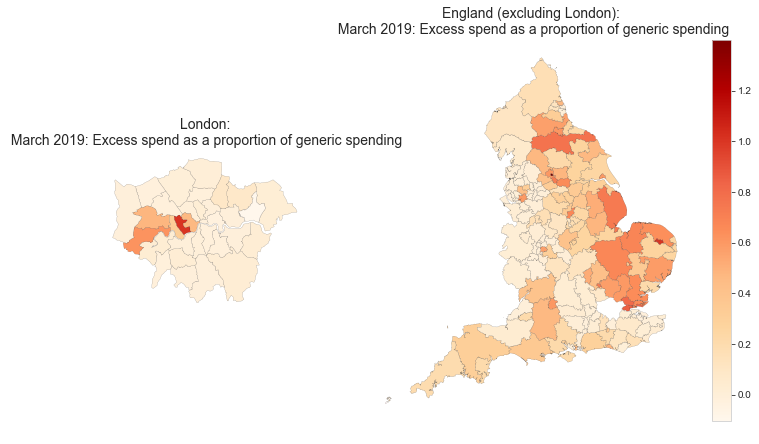

In [88]:
plt.figure(figsize=(12, 7))
ccg_for_map = ccg.loc[ccg['pct']!='112']
last_month = ccg_for_map.loc[ccg['month']==ccg['month'].max()]
maps.ccg_map(last_month, title=" March 2019: Excess spend as a proportion of generic spending", column='calc_val', 
             separate_london=True)
plt.savefig(r'gbg_images\gbg_fig3_ccgmap.png')
plt.show()

# Declie plots

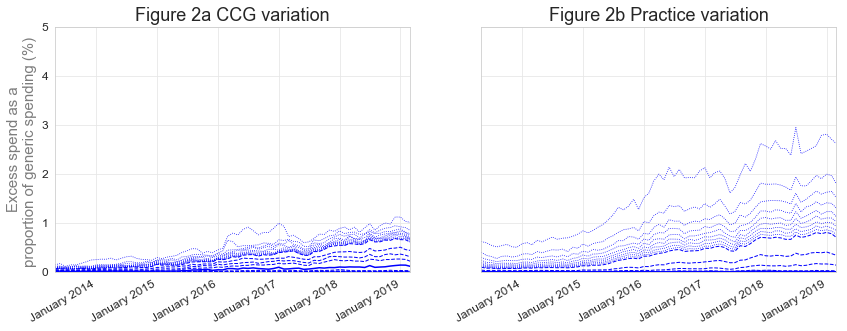

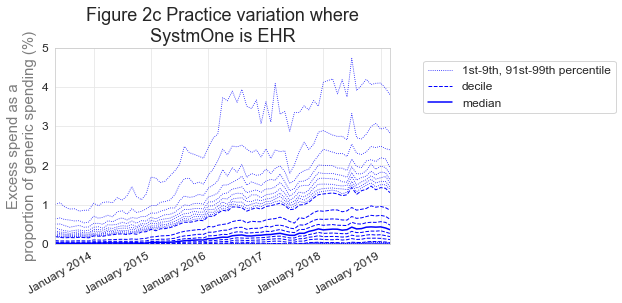

In [139]:
f = plt.figure(figsize=(14, 5))
#f.suptitle('Sharing Y axis')
f.autofmt_xdate()
layout = gridspec.GridSpec(1, 2, figure=f)
left_plot = plt.subplot(layout[0])
right_plot = plt.subplot(layout[1], sharey=left_plot)  # Share the Y axis 

# ...and because it's shared, suppress ticks on the second chart
plt.setp(right_plot.get_yticklabels(), visible=False)

charts.deciles_chart(
    ccg,
    period_column='month',
    column='calc_val',
    title="Figure 2a CCG variation",
    ylabel="Excess spend as a\nproportion of generic spending (%) ",
    show_outer_percentiles=True,
    show_legend=False,
    ax=left_plot,  
) 


charts.deciles_chart(
    practice,
    period_column='month',
    column='calc_val',
    title="Figure 2b Practice variation",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=False,
    ax=right_plot,
) 
plt.ylim(0, 5)

charts.deciles_chart(
        df_sysone_prac,
        period_column='month',
        column='calc_val',
        title="Figure 2c Practice variation where\nSystmOne is EHR",
        ylabel= "Excess spend as a\nproportion of generic spending (%)",
        show_outer_percentiles=True,
        show_legend=True,
   
)
plt.ylim(0, 5)
plt.savefig('deciles.png', format='png', dpi=300,bbox_inches='tight')
plt.savefig(r'gbg_images\gbg_fig2_deciles_ccgprac.png')
plt.show()

# Total items and total excess costs

In [11]:
totals = practice.groupby('month').sum()

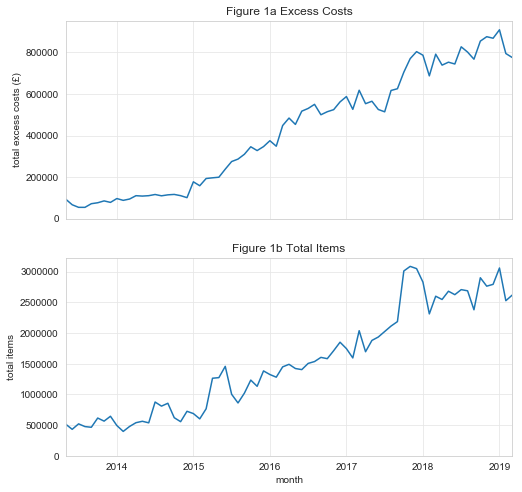

In [12]:
f = plt.figure(figsize=(8, 8))
layout = gridspec.GridSpec(2, 1, figure=f)
top_plot = plt.subplot(layout[0])
bottom_plot = plt.subplot(layout[1], sharex=top_plot)  # Share the Y axis 

ax = totals['possible_savings'].plot(ax=top_plot)
ax.set_ylabel('total excess costs (£)')
ax.set_ylim(0,)
ax.set_title('Figure 1a Excess Costs')
ax = totals['items'].plot(ax=bottom_plot)
ax.set_ylabel('total items')
ax.set_ylim(0,)
ax.set_title('Figure 1b Total Items')
plt.savefig('Fig 1.png', format='png', dpi=300,bbox_inches='tight')
plt.savefig(r'gbg_images\gbg_fig1_totalexcess_costitems.png')
plt.show()

## Annual totals
Ignore 2013 and 2019, as they're not complete years

In [13]:
totals[['items','possible_savings','net_cost']].resample('Y').sum()

,items,possible_savings,net_cost
month,,,
2013-12-31,4230540,579186.29,2923176703.55
2014-12-31,7451006,1275098.39,4399345122.25
2015-12-31,12682756,3052386.53,4653745679.59
2016-12-31,18160750,5807246.05,4538026084.68
2017-12-31,26362166,7409786.86,4548889822.26
2018-12-31,31827681,9496024.33,4220776576.84
2019-12-31,8205775,2479163.77,1030645877.80


# Stratify by EHR

Rerun GPSoC file aggregation if new months need to be added:

In [14]:
#%run -i "GPSoC/make_csv.py"

In [15]:
epr = pd.read_csv('GPSoC/complete.csv')
epr = epr.rename(index=str, columns={"Principal Supplier": "Principal_Supplier",
                                     "Principal System": "Principal_System"})
epr['Date'] = pd.to_datetime(epr['Date'])
epr.loc[epr['Principal_Supplier']=='TPP','Principal_Supplier'] = 'SystmOne'
epr.loc[epr['Principal_Supplier']=='INPS','Principal_Supplier'] = 'Vision'
epr = epr.drop('Unnamed: 0', axis=1)
epr.head()

,Date,ODS,Principal_Supplier,Principal_System
0,2016-04-01,A81622,SystmOne,SystmOne (GPSoC)
1,2016-04-01,A82018,EMIS,EMIS Web
2,2016-04-01,A82041,EMIS,EMIS Web
3,2016-04-01,A86026,SystmOne,SystmOne (GPSoC)
4,2016-04-01,B81120,SystmOne,SystmOne (GPSoC)


In [16]:
epr_march19 = epr.loc[epr['Date']=='2019-03-01',['ODS','Principal_Supplier', 'Date']]
epr_march19.head(5)

,ODS,Principal_Supplier,Date
194018,A81023,SystmOne,2019-03-01
194019,A82018,EMIS,2019-03-01
194020,A84043,SystmOne,2019-03-01
194021,A86026,SystmOne,2019-03-01
194022,B84002,SystmOne,2019-03-01


In [17]:
epr_march19.groupby('Principal_Supplier').count()

,ODS,Date
Principal_Supplier,,
EMIS,4064,4064
Microtest,52,52
SystmOne,2700,2700
Vision,315,315


In [50]:
numbers = practice[['month','practice', 'possible_savings','net_cost']]
first = epr.loc[epr['Date']=='2016-03-01',['ODS','Principal_Supplier']]
last = epr.loc[epr['Date']=='2018-12-01',['ODS','Principal_Supplier']]
by_epr = numbers.merge(epr, how='left', left_on=['practice','month'], right_on=['ODS','Date'])
by_epr = by_epr.merge(first,
                      how='left',
                      left_on='practice',
                      right_on='ODS',
                      suffixes=('','_first')
                     )
'''by_epr = by_epr.merge(last,
                      how='left',
                      left_on='practice',
                      right_on='ODS',
                      suffixes=('','_last')
                     )'''
by_epr.loc[by_epr['month']<'2016-03-01','Principal_Supplier'] = by_epr.loc[by_epr['month']<'2016-03-01','Principal_Supplier_first']
#by_epr.loc[by_epr['month']>'2018-12-01','Principal_Supplier'] = by_epr.loc[by_epr['month']>'2018-12-01','Principal_Supplier_last']
by_epr = by_epr.drop(columns=['Date',
                              'ODS',
                              'Principal_System',
                              'ODS_first',
                              'Principal_Supplier_first'])#,
                              #'ODS_last',
                              #'Principal_Supplier_last'])
by_epr['Principal_Supplier'] = by_epr['Principal_Supplier'].str.strip()
by_epr2 = by_epr.groupby(['month','Principal_Supplier']).sum()
by_epr2 = by_epr2.unstack()
by_epr2.head()

possible_savings                                net_cost  \
Principal_Supplier             EMIS Microtest SystmOne  Vision         EMIS   
month                                                                         
2013-05-01                 10446.77   1784.29 73738.64 5581.46 203238163.99   
2013-06-01                 -2563.73   1859.71 63388.98 2988.00 188462254.12   
2013-07-01                -10055.73    785.86 61007.63 2142.51 203442934.51   
2013-08-01                 -3948.33    534.06 57048.07  979.68 195651805.43   
2013-09-01                  9180.06    736.48 60155.03  885.89 190777930.29   

                                                        
Principal_Supplier  Microtest     SystmOne      Vision  
month                                                   
2013-05-01         5170136.52 135160903.38 26857906.96  
2013-06-01         4789722.81 124830516.81 25017331.23  
2013-07-01         5204418.73 134816177.08 26813963.72  
2013-08-01         5093040.22 130271807.21 25866000.03  
2013-09-01         4851201.65 125962964.12 25384134.39

In [52]:
by_epr.head(5)

,month,practice,possible_savings,net_cost,Principal_Supplier
0,2013-05-01,A81001,3.29,32027.35,SystmOne
1,2013-06-01,A81001,-2.13,27785.40,SystmOne
2,2013-07-01,A81001,0.00,30353.65,SystmOne
3,2013-08-01,A81001,3.35,30748.65,SystmOne
4,2013-09-01,A81001,32.18,29544.21,SystmOne


### EHR Usage by CCG - SystmOne Deciles

In [54]:
ehr_by_ccg = pd.merge(by_epr, practice[['practice', 'month' ,'calc_val']].drop_duplicates(), left_on=['practice', 'month'], right_on= ['practice', 'month'], how='left')
ehr_by_ccg.head(5)

,month,practice,possible_savings,net_cost,Principal_Supplier,calc_val
0,2013-05-01,A81001,3.29,32027.35,SystmOne,0.01
1,2013-06-01,A81001,-2.13,27785.40,SystmOne,-0.01
2,2013-07-01,A81001,0.00,30353.65,SystmOne,0.00
3,2013-08-01,A81001,3.35,30748.65,SystmOne,0.01
4,2013-09-01,A81001,32.18,29544.21,SystmOne,0.11


In [55]:
df_sysone_prac = ehr_by_ccg.loc[ehr_by_ccg['Principal_Supplier']=='SystmOne']
df_sysone_prac.head(5)

,month,practice,possible_savings,net_cost,Principal_Supplier,calc_val
0,2013-05-01,A81001,3.29,32027.35,SystmOne,0.01
1,2013-06-01,A81001,-2.13,27785.40,SystmOne,-0.01
2,2013-07-01,A81001,0.00,30353.65,SystmOne,0.00
3,2013-08-01,A81001,3.35,30748.65,SystmOne,0.01
4,2013-09-01,A81001,32.18,29544.21,SystmOne,0.11


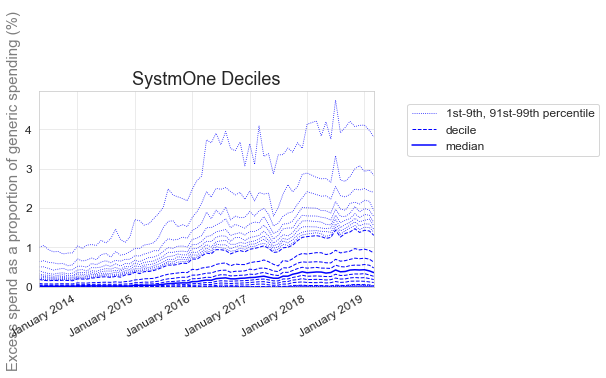

In [56]:
charts.deciles_chart(
        df_sysone_prac,
        period_column='month',
        column='calc_val',
        title="SystmOne Deciles",
        ylabel="Excess spend as a proportion of generic spending (%) ",
        show_outer_percentiles=True,
        show_legend=True
)
plt.savefig('deciles.png', format='png', dpi=300,bbox_inches='tight')
plt.savefig(r'gbg_images\gbg_figx_deciles_pracsysone.png')
plt.show()

## Total possible savings

In [ ]:
f = plt.figure(figsize=(10, 6))
layout = gridspec.GridSpec(1, 1, figure=f)
ax = plt.subplot(layout[0])
ax = by_epr['possible_savings'].plot(ax=ax)
ax.axvline('2018-12-01',color='r',linestyle=':', label='DataLab Identify GBG')
ax.axvline('2019-02-01',color='k',linestyle='--', label='SystmOne delpoy fix')
ax.legend()
ax.set_ylabel('total excess costs (£) ')
ax.set_ylim(0,)
plt.savefig('savings_by_EHR.png', format='png', dpi=300,bbox_inches='tight')
plt.savefig(r'gbg_images\gbg_fig4_totalcosts_ehr.png')
plt.show()

## Total savings/total generic prescribing costs

In [ ]:
measure = by_epr['possible_savings'] / by_epr['net_cost']
measure.head()

In [ ]:
measure.plot()
plt.savefig(r'gbg_images\gbg_figx_measures.png')

# SystmOne Only

In [ ]:
systmone = by_epr['possible_savings']['SystmOne']
systmone.head()

In [ ]:
f = plt.figure(figsize=(8, 5))
layout = gridspec.GridSpec(1, 1, figure=f)
ax = plt.subplot(layout[0])
ax = systmone.plot(ax=ax)
ax.axvline('2018-12-01',color='r',linestyle=':', label='DataLab Identify GBG')
ax.axvline('2019-02-01',color='k',linestyle='--', label='SystmOne delpoy fix') ## it was last week of Feb, I think a case for setting as march
ax.set_ylabel('total excess costs')
ax.set_ylim(0,)
ax.legend()
plt.savefig('systmone_only.png', format='png', dpi=300,bbox_inches='tight')
plt.savefig(r'gbg_images\gbg_fig5_systmone.png')
plt.show()

# Top ten GBG chemicals in 2018

In [ ]:
sql = """
WITH
  chem_map AS(
  SELECT
    DISTINCT chemical_code,
    chemical
  FROM
    ebmdatalab.hscic.bnf)
SELECT
  SUBSTR(bnf_code,1,9) AS chem_code,
  chemical,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN items ELSE 0 END) AS items,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN possible_savings ELSE 0 END) AS excess_spend
FROM
  ebmdatalab.alex.vw__ghost_generic_measure_paper
INNER JOIN
  ebmdatalab.hscic.practices
ON
  practice = code
  AND setting = 4
LEFT JOIN
  chem_map
ON
  SUBSTR(bnf_code,1,9) = chemical_code
WHERE
  month >= '2018-01-01'
  AND month <= '2018-12-01'
GROUP BY
  chem_code,
  chemical
ORDER BY
  excess_spend DESC
"""
by_chem = bq.cached_read(sql, csv_path='by_chem.zip')

In [ ]:
by_chem.head(10)

In [ ]:
by_chem.sort_values('items',ascending=False).head(10)